# TP Final - Análisis de Datos (CEIA - FIUBA)

**Integrantes:**
- Carolina Perez Omodeo
- Federico Arias Suárez
- Emiliano Uriel Martino
- Diego José Araujo Arellano

In [124]:
# ---------------- Paquetes a utilizar ----------------

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import folium # Para dibujar mapas
from folium import plugins
from IPython.display import display

pd.options.mode.chained_assignment = None

In [125]:
# ---------------- Carga de datos ----------------

df = pd.read_csv("listings_full.csv", low_memory=False)

# Se guardan los datos originales para poder acceder a ellos y trabajamos sobre el df
datos_originales = df

In [126]:
# ---------------- Transformación de variables ---------------- 



## 1. Introducción y Motivación

En los últimos años, la popularidad de las plataformas de alojamiento temporal, como Airbnb, ha experimentado un notable crecimiento a nivel global. Buenos Aires, como una de las ciudades más visitadas de América Latina, no es la excepción. La variabilidad de los precios de los alojamientos en diferentes barrios de la ciudad despierta el interés tanto de los anfitriones, que buscan maximizar sus ingresos, como de los huéspedes, que desean obtener la mejor relación calidad-precio.

El presente análisis de datos tiene como objetivo comprender los factores que influyen en los precios de los alojamientos en Airbnb en la ciudad de Buenos Aires. Mediante la recopilación y el análisis de datos detallados sobre los precios, se pretende identificar patrones y tendencias que puedan ser útiles para distintos stakeholders. Por ejemplo, los propietarios de alojamientos pueden optimizar sus precios, mientras que los viajeros pueden tomar decisiones más informadas.

Una motivación clave detrás de este análisis es la creación de un modelo predictivo. Utilizando atributos específicos de los alojamientos, tales como la ubicación, el tamaño, la cantidad de habitaciones, las comodidades ofrecidas, entre otros, se busca entrenar un modelo de machine learning capaz de predecir el precio de un alojamiento en función de estos factores. Este modelo no solo permitirá prever los precios con mayor precisión, sino que también podrá ser una herramienta valiosa para el análisis comparativo y la toma de decisiones estratégicas.

Además, una parte fundamental de este estudio es la visualización geográfica de los precios. Utilizando la librería Folium de Python, se desarrollará un mapa interactivo que mostrará la distribución de los precios de los alojamientos por barrios en Buenos Aires. Esta visualización permitirá identificar fácilmente áreas con precios más altos o más bajos, facilitando así una comprensión espacial de las dinámicas del mercado de Airbnb en la ciudad.

## 2. Análisis exploratorio inicial

#### 2.1 Visualizar las primeras filas.

In [127]:
# ---------------- Visualización de las primeras filas ---------------- 

pd.options.display.max_columns = None
pd.options.display.max_rows = None
df.head(5,)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,111501,https://www.airbnb.com/rooms/111501,20240428134723,2024-04-29,city scrape,Sunny Apartment Palermo Boulevard Cerviño,Discover your perfect temporary home in Buenos...,The neighborhood is one of the best places to ...,https://a0.muscache.com/pictures/hosting/Hosti...,570921,https://www.airbnb.com/users/show/570921,Emilce,2011-05-09,"Buenos Aires, Argentina","Hello there! I'm Emilce, Airbnb host since man...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/869a3...,https://a0.muscache.com/im/pictures/user/869a3...,Palermo,2,2,"['email', 'phone']",t,t,"Buenos Aires, Capital Federal, Argentina",Palermo,NaN,-34.57901,-58.41283,Entire rental unit,Entire home/apt,4,1.0,1 bath,0.0,2.0,"[""Hair dryer"", ""Bidet"", ""Outdoor furniture"", ""...","$41,089.00",4,730,4,4,730,730,4.0,730.0,NaN,t,27,56,58,314,2024-04-29,155,12,1,2011-08-03,2024-04-03,4.79,4.89,4.72,4.92,4.97,4.96,4.81,NaN,f,2,2,0,0,1.00
1,111934,https://www.airbnb.com/rooms/111934,20240428134723,2024-04-29,city scrape,Bright Studio at Palermo Soho,Discover this bright studio in the heart of Pa...,"Palermo Soho is a fashionable neighborhood, fu...",https://a0.muscache.com/pictures/3002473/ce07a...,570921,https://www.airbnb.com/users/show/570921,Emilce,2011-05-09,"Buenos Aires, Argentina","Hello there! I'm Emilce, Airbnb host since man...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/869a3...,https://a0.muscache.com/im/pictures/user/869a3...,Palermo,2,2,"['email', 'phone']",t,t,"Buenos Aires, Capital Federal, Argentina",Palermo,NaN,-34.58199,-58.42776,Entire rental unit,Entire home/apt,2,1.0,1 bath,0.0,1.0,"[""Hair dryer"", ""Window guards"", ""Bidet"", ""BBQ ...","$34,847.00",4,730,4,4,730,730,4.0,730.0,NaN,t,20,50,80,355,2024-04-29,131,22,0,2011-05-23,2024-02-26,4.78,4.80,4.79,4.85,4.90,4.83,4.69,NaN,f,2,2,0,0,0.83
2,11508,https://www.airbnb.com/rooms/11508,20240428134723,2024-04-29,city scrape,Amazing Luxurious Apt-Palermo Soho,LUXURIOUS 1 BDRM APT- POOL/ GYM/ SPA/ 24-HR SE...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,https://www.airbnb.com/users/show/42762,Candela,2009-10-01,"New York, NY",-,within a day,100%,90%,t,https://a0.muscache.com/im/users/42762/profile...,https://a0.muscache.com/im/users/42762/profile...,Palermo,1,2,"['email', 'phone']",t,t,"Buenos Aires, Capital Federal, Argentina",Palermo,NaN,-34.58184,-58.42415,Entire condo,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Air conditioning"", ""Hair dryer"", ""Paid stree...","$59,325.00",3,1125,3,3,1125,1125,3.0,1125.0,NaN,t,1,31,61,336,2024-04-29,40,5,0,2012-07-02,2024-03-05,4.80,4.92,4.87,4.92,4.97,4.92,4.8

#### 2.2 Realizar un resumen de 5 números

In [128]:
# ---------------- Resumen de algunos números ---------------- 

df.loc[:,['bedrooms','beds','bathrooms','review_scores_value','price']].describe()

,bedrooms,beds,bathrooms,review_scores_value
count,35994.00000,33893.000000,33900.000000,29654.000000
mean,1.17728,1.678075,1.233820,4.747091
std,0.89631,1.591133,0.628285,0.360441
min,0.00000,0.000000,0.000000,1.000000
25%,1.00000,1.000000,1.000000,4.670000
50%,1.00000,1.000000,1.000000,4.840000
75%,1.00000,2.000000,1.000000,5.000000
max,35.00000,36.000000,22.000000,5.000000


#### 2.3 Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [129]:
# ---------------- Tipos de datos ---------------- 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36561 entries, 0 to 36560
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36561 non-null  int64  
 1   listing_url                                   36561 non-null  object 
 2   scrape_id                                     36561 non-null  int64  
 3   last_scraped                                  36561 non-null  object 
 4   source                                        36561 non-null  object 
 5   name                                          36561 non-null  object 
 6   description                                   35718 non-null  object 
 7   neighborhood_overview                         18608 non-null  object 
 8   picture_url                                   36561 non-null  object 
 9   host_id                                       36561 non-null 

El dataset contiene varios campos (unos 74 en total), donde predominan las variables numéricas (41 vars.) y en menor medida variables del tipo *object* (no necesariamente categóricas).

**Variables numéricas**

Se presentan variables numéricas, tanto en valores enteros (*"int64"*), como en representaciones de punto flotante de doble precisión (*"float64"*). Algunos ejemplos de esto: 
- ***int64:*** se utilizan por lo general para hacer conteos e.g. *host_id, minimum_nights, number_of_reviews*.
- ***float64:*** se utilizan cuando se necesita representar números con varios decimales, como puede en el caso de coordenadas, e.g. *latitude, longitude, review_scores_values*.

**Variables categóricas**

Algunas variables categóricas que se pueden encontrar dentro del dataset (de tipo *"object"*), son: 
- **neighbourhood_cleansed:** que refiere al barrio donde está ubicado el alojamiento. Presenta unas 48 categorías, por lo quizás sería bueno poder agruparlos en *macro categorías* (regiones, municipios, otros) para simplificar el análisis.
- **property_type:** el tipo de propiedad (*casa, hotel, villa, etc.*). Presenta unas 78 categorías, por lo que de utilizarla sería interesante agruparlas y también presenta datos *sucios* (e.g. denominaciones en inglés y en español).
- **room_type:** que refiere a opciones en cuanto tipo de alojamiento (*'Entire home/apt', 'Private room', 'Hotel room', 'Shared room'*). 

**Variables compuestas (tipo "object")**

Como se decía anteriormente, predomina el tipo de dato *object*, que, si bien se utiliza por lo general para cadenas de texto (*strings*), puede contener cualquier tipo de dato. Algunos datos que se presentan como object, pero que podrían referir a un tipo específico de dato son:

- **Fechas:** e.g. última actualización de los datos (*last_scraped*), última puntuación (*'last_review'*), desde cuando está el host en la plataforma (*'host_since'*).
- **Lógicos:** o booleanos (`True` o `False`), e.g. la etiqueta de si el host es *superhost* (*'host_is_superhost'*), si tiene disponibilidad (*'has_availability'*).
- **Listas:** e.g. listas que indican las facilidades (*amenities*), o las verificaciones del host (*'host_verifications'*).




#### 2.4 Identificar las variables de entrada y de salida del problema.

En nuestro caso vamos a predecir el precio de alquiler por noche, para ello vamos a usar las columnas:

**Variables de entrada**

- **host_name** (object): Nombre del host.
- **host_since** (object): tiempo desde que el dueño de casa esta en la plataforma de AirBnb. Habría que cambiar a tipo datetime si se quiere usar en cálculos de tiempos.
- **host_is_superhost** (object): si el anfitrión está en la categoría de *super host*.
- **bathrooms** (float64): cantidad de baños.
- **bathrooms_text** (object): Cantidad de baños en formato texto. Se agrega luego de un primer análisis exploratorio, más adelante se explica el porqué.
- **bedrooms** (int64): cantidad de cuartos del alojamiento.
- **beds** (int64): cantidad de camas.
- **amenities** (object): lista de comodidades que tiene el alojamiento.
- **number_of_reviews** (int64): Cantidad de reviews que recibió el alojamiento.
- **review_scores_rating** (float64): Puntuación del alojamiento.
- **reviews_per_month** (float64): Cantidad de reviews por mes.
- **latitude** (float64): Coordenada geográfica/Latitud.
- **longitude** (float64): Coordenada geográfica/Longitud.
- **property_type** (object): Tiene 70 categorías, se podría agrupar en macrocategorías
- **availability_30** (int64): Disponibilidad a 30 días 
- **availability_60** (int64): Disponibilidad a 60 días 
- **availability_90** (int64): Disponibilidad a 90 días 

**Variables de salida** 
- **price** (object): Es la variable objetivo, viene en formato texto por lo que hay que transformarla.

In [130]:
# 'price' parece ser un objeto, por lo que habría que convertir en float
df['price'] = df['price'].str.replace('$','',regex=True).str.replace(',','',regex=True).astype('float')

In [131]:
df = df[['id','name', 'host_name', 'host_since', 'host_is_superhost', 'neighbourhood_cleansed', 'bathrooms', 'bathrooms_text','bedrooms', 
        'beds', 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month','latitude', 'longitude',
        'property_type', 'room_type', 'availability_30', 'availability_60','availability_90']]

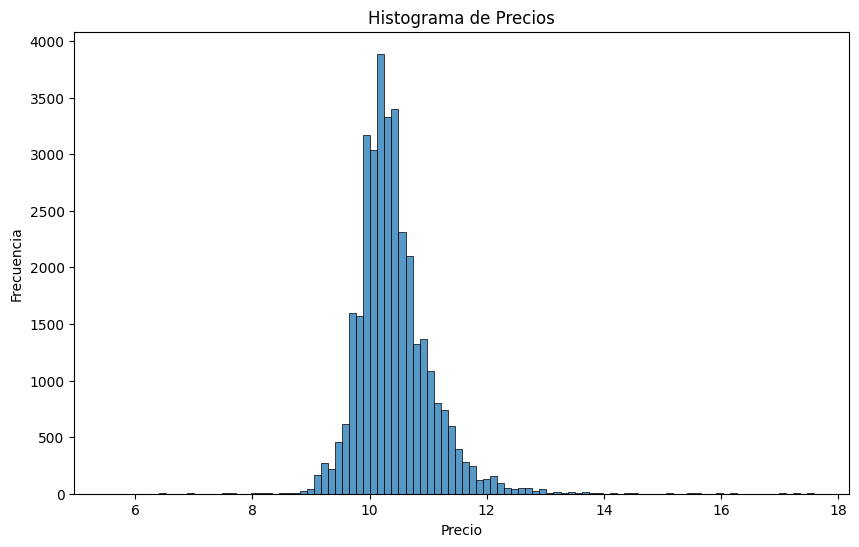

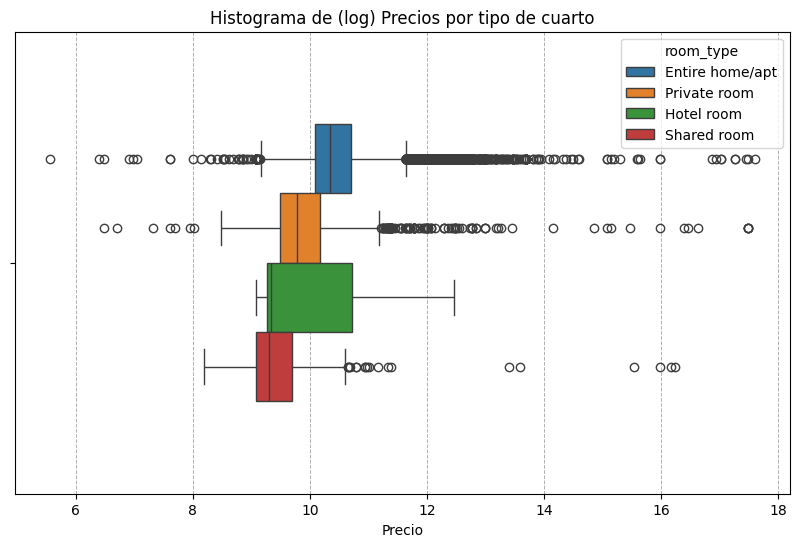

In [132]:
# Histograma para ver como están distribuidos los precios de los alquileres
# En este caso estaría mejor utilizar el log de los precios, dado que tienen valores muy bajos / altos, por lo que se agrega al dataset una variable más (log_price), 
# para utilizar más adelante cualquier cosa

df['log_price'] = np.log(df['price'])

plt.figure(figsize=(10, 6))
sns.histplot(x=df['log_price'], bins=100)
plt.title('Histograma de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x ='log_price', hue='room_type', width=0.6, dodge=True)
plt.title('Histograma de (log) Precios por tipo de cuarto')
plt.xlabel('Precio')

# Añadir separación vertical entre los boxplots
plt.grid(axis='x', linestyle='--', linewidth=0.7)

plt.show()

In [133]:
df.groupby('room_type')['price'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,31152.0,54037.27,549208.04,260.0,23858.0,31219.0,44463.0,43711503.0
Hotel room,67.0,39959.72,56243.31,8742.0,10491.0,11365.0,44962.0,256648.0
Private room,2469.0,118408.72,1677574.17,650.0,13113.0,17485.0,26227.0,39340353.0
Shared room,223.0,183185.41,1229733.35,3600.0,8742.0,10875.0,16233.5,11240098.0


## 3. Limpieza y preparación de datos / ingeniería de features

#### 3.1 Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable.

In [134]:
# Se crea una función para ver valores faltantes de atributos que componen el dataset

def miss_data(df, col):
    
    # Total de filas del df original
    total_filas = len(df)
    
    # Lista para ir agregando los resultados
    resultados = []

    for var in col:
        valores_faltantes = df[var].isna().sum()
        proporcion_faltantes = valores_faltantes/total_filas
        resultados.append({
            'Columna': var,
            'Total_Filas': total_filas,
            'Valores_Faltantes': valores_faltantes,
            'Prop_faltantes': proporcion_faltantes
        })
    
    resultado_df = pd.DataFrame(resultados)
    
    return resultado_df

In [135]:
# Vamos a ver que atributos tienen datos faltantes, la cantidad de los mismos y la proporción con respecto al total de datos
df_faltantes = miss_data(df, list(df.columns)).sort_values('Prop_faltantes', ascending=False)

# Nos quedamos solo con aquellas variables que tienen datos faltantes
df_faltantes[df_faltantes['Prop_faltantes'] > 0]


,Columna,Total_Filas,Valores_Faltantes,Prop_faltantes
14,reviews_per_month,36561,6882,0.188233
13,review_scores_rating,36561,6882,0.188233
9,beds,36561,2668,0.072974
6,bathrooms,36561,2661,0.072782
11,price,36561,2650,0.072482
22,log_price,36561,2650,0.072482
8,bedrooms,36561,567,0.015508
4,host_is_superhost,36561,65,0.001778
7,bathrooms_text,36561,26,0.000711


#### 3.2 ¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación recomendaría? Ensayar distintas técnicas y analizar los resultados.

Se puede ver que, de acuerdo al total de filas del dataframe, tenemos 36.561 observaciones. Como se observa en la tabla anterior, algunos atributos presentan datos faltantes (con su peso relativo respecto a la cantidad de datos) que pueden darse por distintas causas. En principio nos enfocamos en la variable objetivo *"precio"*, que nos interesa poder tenerla como un dato completo, de forma de poder utilizar alguna técnica de aprendizaje supervisado para poder predecir el precio del alojamiento según sus atributos.

In [136]:
# Parece que los nulos en precios son del scraping anterior, por eso faltan esos datos...
print(f'Fuente de datos:')
print(datos_originales['source'].unique())
datos_originales.groupby('source')['price'].apply(lambda x: x.isnull().sum())

Fuente de datos:
['city scrape' 'previous scrape']


source
city scrape           0
previous scrape    2650
Name: price, dtype: int64

En este caso se puede ver un claro ejemplo de datos faltantes al azar (**MAR**), dado que la falta de datos se puede explicar por el valor de otras columnas (en este caso por *source*). No se tiene mayor información sobre *source*, pero se puede inferir que para la obtención de datos del dataset, se tomaron 2 fuentes distintas (o en defecto, se aplicaron 2 técnicas de *scraping*), en la que la más reciente (*city scrape*) pudo acceder a datos que la anterior (*previous scrape*) no traía.

Otra variable que presenta datos faltantes al azar, es el rating (*review_scores_rating*), que se podría entender fundamental a la hora de setear el precio del alojamiento (i.e. "lugares mejores puntuados tendrían precios más elevados"). En este caso también se presentan datos faltantes al azar, ya que la falta de puntuaciones responde simplemente a que esos alojamientos aún no tienen *reviews*. Si observamos la cantidada de reviews (*number_of_reviews*), vemos que hay 6.882 valores con 0 puntuación, lo que coincide con la cantidad de valores faltantes de la puntuación. Esto se podría entender cómo propiedades nuevas en la plataforma y que si bien están ofertadas, aún no hubo demanda por ellas.

In [137]:
# Cantidad de alojamientos sin puntuación
print(f" Cantidad de alojamientos sin reviews: { sum(df['number_of_reviews'] == 0)}")

# Vamos a asegurarnos que los que tienen NAN en puntuación, son efectivamente los que tienen cantidad 0 de reviews
print(f" Cantidad de los anteriores con NAN en rating: {df[df['number_of_reviews'] == 0]['review_scores_rating'].isna().sum()}")

 Cantidad de alojamientos sin reviews: 6882
 Cantidad de los anteriores con NAN en rating: 6882


Otras variables con datos faltantes que podrían incidir en el precio, son la cantidad de ambientes que puede tener el alojamiento (i.e. *"a mayor cantidad de ambientes, más elevado el precio"*). En este dataset, se tiene información de 2 en particular que parecen relevantes: el número de cuartos (*bedrooms*) y la cantidad de baños (*bathrooms*). En ambos no se distingue un patrón alguno del faltante de datos (como se veía anteriormente en *price-souce*), por lo que pueden ser faltantes completamente por azar (**MCAR**).

Mientras que en la variable *bathrooms* faltan algunos valores (2.661 filas), en la variable *bathrooms_text* se observa que la cantidad de baños está casi completa (tiene 26 filas con datos faltantes), solo que están como una etiqueta, en formato texto (e.g. *1 bath*). Haciendo una transformación de esta última variable, podríamos completar los datos faltantes de *bathrooms*. Otro factor a considerar es que en el dataset se presentan cantidades de baños decimales (e.g. 1.5), lo cual en principio parece incorrecto. Explorando las publicaciones se puede detectar que lo que se considera "medio baño" puede ser por varias causas:
- El tamaño
- Baños auxiliares (*de tocador*)
- Baños compartidos

A los efectos del análisis se determinan estos *medios baños* como enteros (porque en definitiva también lo son), así que se redondearán.

In [138]:
# Categorías que presenta la variable bathrooms_text
df['bathrooms_text'].unique()

array(['1 bath', '1.5 baths', '1.5 shared baths', '2 baths', nan,
       '5.5 baths', '1 shared bath', '2.5 baths', '3 baths', '0 baths',
       '2 shared baths', '1 private bath', '6 baths', '2.5 shared baths',
       '5 baths', '4 baths', '3.5 baths', '4 shared baths',
       '6 shared baths', '3 shared baths', '0 shared baths',
       '3.5 shared baths', 'Private half-bath', 'Half-bath', '9 baths',
       '8 shared baths', '4.5 baths', 'Shared half-bath',
       '5.5 shared baths', '7 baths', '4.5 shared baths', '22 baths',
       '7 shared baths', '6.5 shared baths', '10 baths', '9.5 baths',
       '16 baths', '7.5 baths', '13 baths', '8 baths', '8.5 shared baths',
       '7.5 shared baths', '6.5 baths', '5 shared baths',
       '9 shared baths', '12.5 baths', '8.5 baths', '15 baths',
       '20 baths'], dtype=object)

In [139]:
# Se hacen las transformaciones necesarias para pasar a formato numérico *bathrooms_text* 

df['bathrooms_text'].replace("Half-bath",1,inplace=True)
df['bathrooms_text'].replace("Private half-bath",1,inplace=True)
df['bathrooms_text'].replace("Shared half-bath",1,inplace=True)

df['bathrooms_text'] = df['bathrooms_text'].str.replace(' shared baths','',regex=True).str.replace(' shared bath','',regex=True).str.replace(' private bath','',regex=True)
df['bathrooms_text'] = df['bathrooms_text'].str.replace(' baths','',regex=True).str.replace(' bath','',regex=True)

df['bathrooms_text'] = df['bathrooms_text'].astype('float').round(0)

# bathrooms si bien tiene valores numéricos, también se presentaba con tupo objeto
df['bathrooms'] = df['bathrooms'].astype('float').round(0)

In [140]:
# Categorías que presenta la variable bathrooms_text luego de transformación
df['bathrooms_text'].unique()

array([ 1.,  2., nan,  6.,  3.,  0.,  5.,  4.,  9.,  8.,  7., 22., 10.,
       16., 13., 12., 15., 20.])

In [141]:
# Ahora usamos esto para sustituir valores faltantes de bathrooms
print(f"Cantidad de valores faltantes en bathrooms antes de transformación: {df['bathrooms'].isna().sum()}")
df['bathrooms'] = df.apply(lambda row: row['bathrooms_text'] if pd.isna(row['bathrooms']) else row['bathrooms'], axis=1)
print(f"Cantidad de valores faltantes en bathrooms después de transformación: {df['bathrooms'].isna().sum()}")

Cantidad de valores faltantes en bathrooms antes de transformación: 2661
Cantidad de valores faltantes en bathrooms después de transformación: 25


Así que logramos limpiar lo más posible esta variable. En cuanto a cantidad de cuartos, como se comentaba anteriormente, no hay un patrón claro, pero los valores faltantes (567 filas) representan en el entorno del 1.6% del total de datos, por lo que seguramente podríamos desestimar estas observaciones para nuestro análisis. Pasemos a imputar los datos faltantes en el precio. 

Parece ser que el barrio es algo determinante en el alquiler de los alojamientos. Se tratará de situar las locaciones en un mapa, para ver si hay un patrón claro.

##### Visualización de mapa

In [142]:
from ipyleaflet import Map, Marker, Popup
from ipywidgets import HTML

In [ ]:
# Mapa centrado de los datos (a través de la mediana)
center_map = [df['latitude'].median(), df['longitude'].median()]
df_map = folium.Map(location=center_map, zoom_start=12)

# Colormap para los precios 
norm = mpl.colors.Normalize(vmin=df['log_price'].min(), vmax=df['log_price'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='YlOrRd')  

# Función para escalar los valores de 'price' a radios y asignar tamaño de acuerdo al precio
def scale_radius(price, min_price, max_price, min_radius, max_radius):
    scaled_radius = ((price - min_price) / (max_price - min_price)) * (max_radius - min_radius) + min_radius
    return scaled_radius

# Valores mínimos y máximos de precio
min_price = df['price'].min()
max_price = df['price'].max()

# Valores mínimos y máximos del radio
min_radius = 5
max_radius = 20

# Función para añadir puntos al mapa
def add_circle_marker(row):
    color = mpl.colors.to_hex(cmap.to_rgba(row['log_price']))
    radius = scale_radius(row['log_price'], min_price, max_price, min_radius, max_radius)
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,  # Radio del círculo
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=folium.Popup(f"<b>{row['name']} <br> Rating: {row['review_scores_rating']} | Reviews ({row['number_of_reviews']}) </b> <br> "
                           f"Barrio: {row['neighbourhood_cleansed']} <br> Host: {row['host_name']}  <br> Precio: ${row['price']}",
                           min_width=150, max_width=200),
        tooltip=row['id']
    ).add_to(df_map)

# Se aplica la función a cada fila del DataFrame
df.apply(lambda row: add_circle_marker(row), axis=1)

# Plugins - Minimapa
minimap = plugins.MiniMap()
df_map.add_child(minimap)
df_map

# Visualización del mapa
df_map


En el mapa anterior no se pueden identificar claramente las zonas más baratas/caras para alquilar. Quizás lo mejor es segmentar por barrio y tomando una medida de centralización de los precios como puede ser la mediana (más robusta).

In [ ]:
# Mapa centrado de los datos (a través de la mediana)
center_map = [df['latitude'].median(), df['longitude'].median()]
df_map = folium.Map(location=center_map, zoom_start=11)

# Función para calcular la mediana de precios por barrio
def medianprice_neighbourhood(df):
    median_prices = df.groupby('neighbourhood_cleansed')['price'].median().reset_index()
    median_prices = median_prices.rename(columns={'price': 'median_price'})
    return df.merge(median_prices, on='neighbourhood_cleansed')

# Aplicar la función a los datos
df = medianprice_neighbourhood(df)

# Colormap para los precios 
norm = mpl.colors.Normalize(vmin=df['median_price'].min(), vmax=df['median_price'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='YlOrRd')  

# Función para escalar los valores de 'price' a radios y asignar tamaño de acuerdo al precio
def scale_radius(price, min_price, max_price, min_radius, max_radius):
    scaled_radius = ((price - min_price) / (max_price - min_price)) * (max_radius - min_radius) + min_radius
    return scaled_radius

# Valores mínimos y máximos de precio
min_price = df['price'].min()
max_price = df['price'].max()

# Valores mínimos y máximos del radio
min_radius = 5
max_radius = 20

# Función para añadir puntos al mapa
def add_circle_marker(row):
    color = mpl.colors.to_hex(cmap.to_rgba(row['median_price']))
    radius = scale_radius(row['log_price'], min_price, max_price, min_radius, max_radius)
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,  # Radio del círculo
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=folium.Popup(f"<b>{row['name']} <br> Rating: {row['review_scores_rating']} | Reviews ({row['number_of_reviews']}) </b> <br> "
                           f"Barrio: {row['neighbourhood_cleansed']} <br> Host: {row['host_name']}  <br> Precio: ${row['price']}",
                           min_width=150, max_width=200),
        tooltip=row['id']
    ).add_to(df_map)

# Se aplica la función a cada fila del DataFrame
df.apply(lambda row: add_circle_marker(row), axis=1)

# Plugins - Minimapa
minimap = plugins.MiniMap()
df_map.add_child(minimap)
df_map

# Visualización del mapa
df_map


Ahora si se pueden detectar zonas de renta donde el precio parece ser más elevado, siguiendo el patrón que cuanto más cercano a la costa, más aumenta la renta temporal de estas propiedades. Esto también se puede ver en la siguiente gráfica.

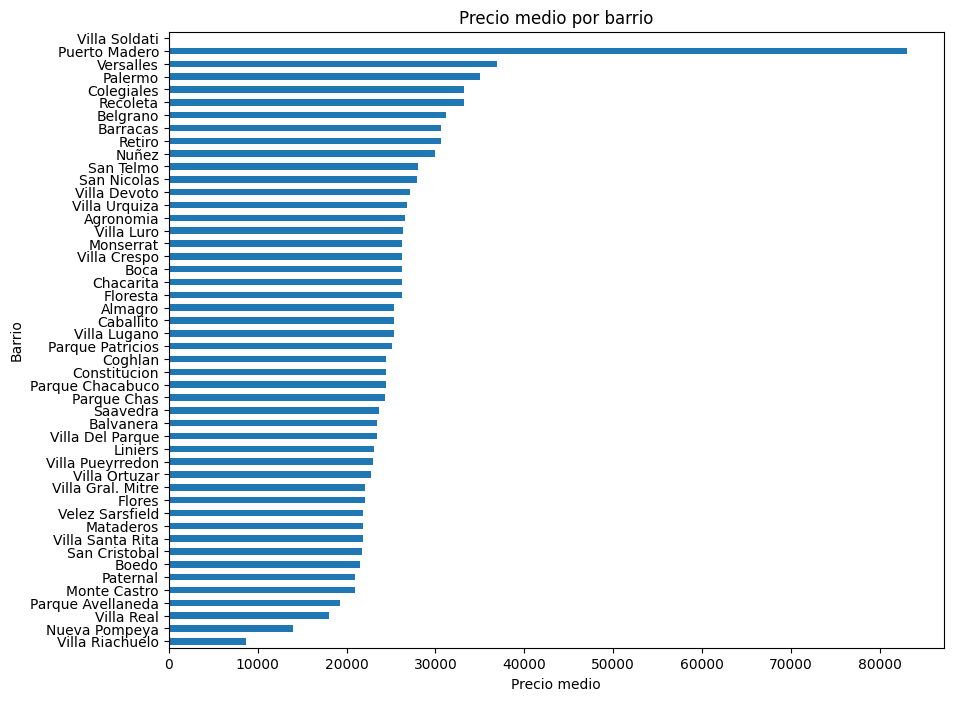

In [145]:
# Gráfico del precio por barrio
df_sorted = df.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8)) 
df_sorted.plot(kind='barh', ax=ax)

plt.xlabel('Precio medio') 
plt.ylabel('Barrio') 
plt.title('Precio medio por barrio') 

plt.show()

Así que para imputar los datos faltantes de precios, nos basaremos en una imputación simple a través de la mediana de cada barrio. Si bien esto puede distorsionar la distribución original, son relativamente pocos datos los que habría que imputar.

In [146]:
# Vamos a dejar un flag para saber que datos imputamos
df['miss_price'] = df['price'].isna()

In [147]:
# Se calculan las medianas para cada barrio
medianas_por_neighbourhood = df.groupby('neighbourhood_cleansed')['price'].median()

# Se crea una función para imputar la mediana del precio por barrio
def imputar_mediana(row):
    if pd.isna(row['price']):
        return medianas_por_neighbourhood[row['neighbourhood_cleansed']]
    else:
        return row['price']

# Aplicar la función a cada fila del DataFrame
df['price'] = df.apply(imputar_mediana, axis=1)

In [148]:
# Queda solamente un alojamiento sin precio en "Villa Soldati", que al ser el único en ese barrio, no se puede imputar el dato
df[df['neighbourhood_cleansed'] == "Villa Soldati"]


,id,name,host_name,host_since,host_is_superhost,neighbourhood_cleansed,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,reviews_per_month,latitude,longitude,property_type,room_type,availability_30,availability_60,availability_90,log_price,median_price,miss_price
36560,34492123,Muy buen hambiente..tranquilidad y espacio,Nilsa,2019-05-07,f,Villa Soldati,1.0,1.0,NaN,NaN,"[""Kitchen"", ""Air conditioning"", ""Wifi"", ""Essen...",NaN,0,NaN,NaN,-34.65719,-58.44229,Private room in home,Private room,0,0,0,NaN,NaN,True


In [149]:
# Se saca lo anterior
df = df[df['neighbourhood_cleansed'] != "Villa Soldati"]
df.shape

(36560, 25)

#### 3.3 En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

#### 3.4 ¿Qué puede decir acerca de las relaciones entre las variables de entrada?

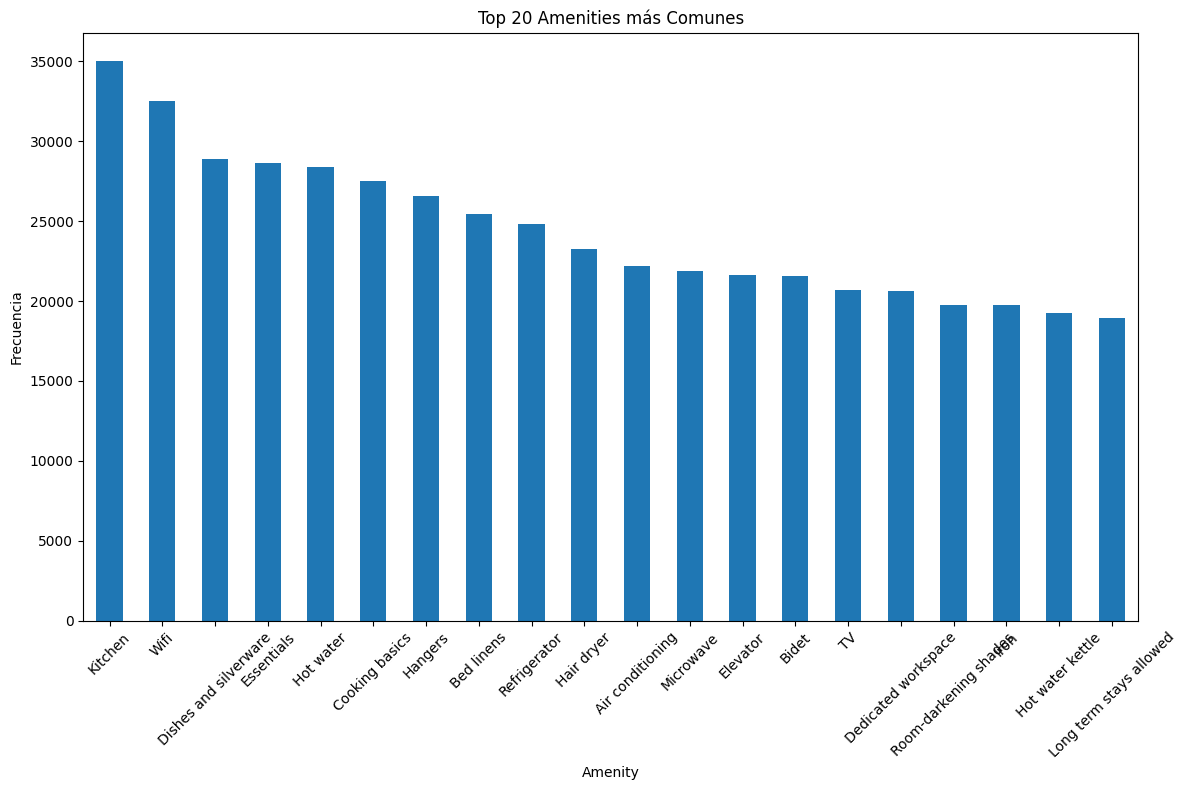

In [150]:
#Vamos a tratar a las amenities distinto por ser una lista de items dentro de cada registro:
import ast

# Convertir las cadenas de texto a listas de Python
df['amenities'] = df['amenities'].apply(ast.literal_eval)
# Explode la columna 'amenities' para que cada amenity tenga su propia fila
df_exploded = df.explode('amenities')
# Contar la frecuencia de cada amenity
amenity_counts = df_exploded['amenities'].value_counts()
# Obtener los 20 amenities más comunes
top_20_amenities = amenity_counts.head(20)

# Paso 4: Graficar los 20 amenities más comunes
plt.figure(figsize=(12, 8))
top_20_amenities.plot(kind='bar')
plt.title('Top 20 Amenities más Comunes')
plt.xlabel('Amenity')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ahora vamos con la correlacion:

In [151]:
df['property_type'].value_counts().tail(60)

Room in hotel                         126
Private room in serviced apartment    117
Private room in bed and breakfast     109
Shared room in rental unit             84
Private room in guesthouse             67
Shared room in home                    53
Casa particular                        52
Room in boutique hotel                 51
Entire townhouse                       50
Private room in villa                  40
Room in bed and breakfast              37
Private room in townhouse              35
Shared room in hostel                  28
Shared room in guesthouse              28
Room in aparthotel                     28
Entire guesthouse                      26
Entire villa                           22
Entire guest suite                     21
Private room in hostel                 19
Room in hostel                         19
Entire place                           19
Private room in guest suite            16
Private room in loft                   14
Shared room in bed and breakfast  

In [152]:
drop_property_list = df['property_type'].value_counts().tail(60).index.to_list()

df = df[~df['property_type'].isin(drop_property_list)]  #len -> paso de 36561 a 35363
#Vamos a drop aquellos registros que son property type count < 126
len(df)

35362

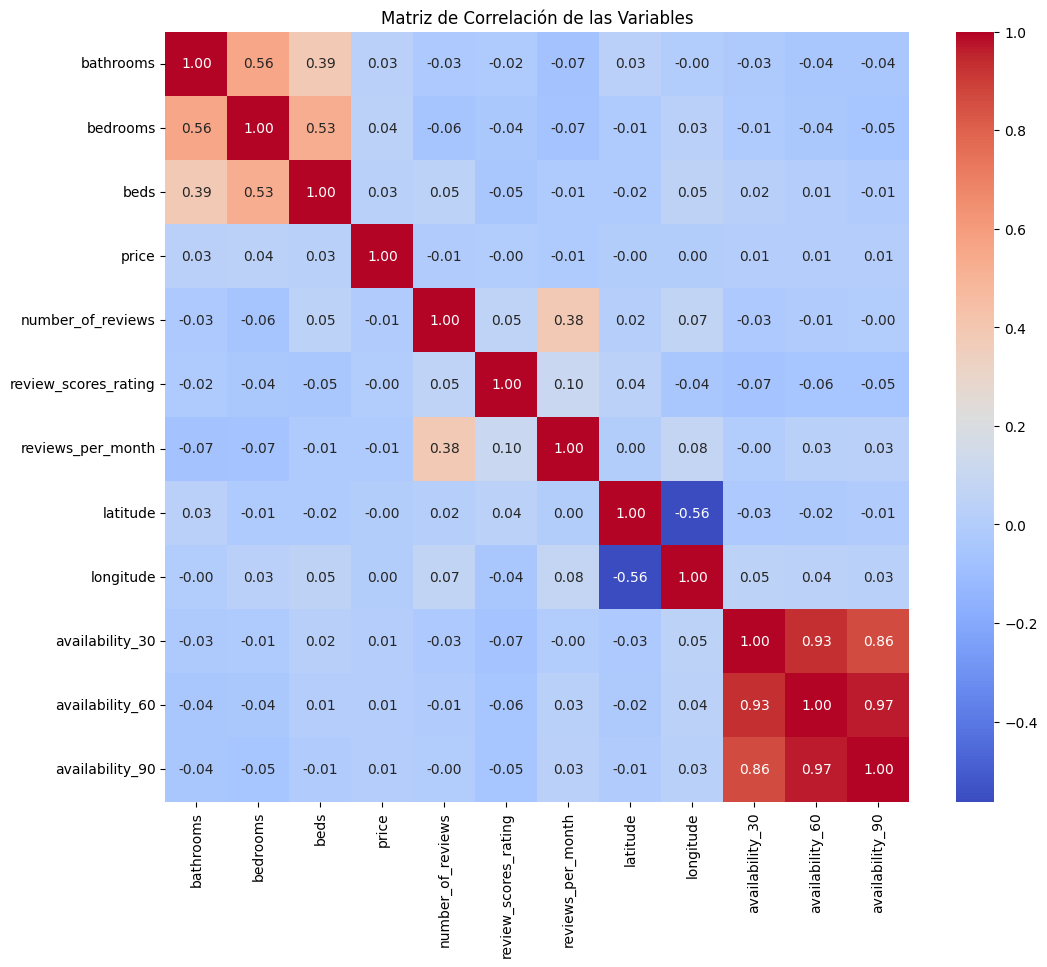

In [153]:
correlation_matrix = df[['bathrooms','bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'latitude', 'longitude', 'availability_30', 'availability_60', 'availability_90']].corr()

plt.figure(figsize=(12, 10))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de las Variables')

plt.show()

In [154]:
df[['bathrooms','bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'latitude', 'longitude', 'availability_30', 'availability_60', 'availability_90']].corr()

,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,reviews_per_month,latitude,longitude,availability_30,availability_60,availability_90
bathrooms,1.000000,0.558214,0.385713,0.032251,-0.026851,-0.015935,-0.069044,0.031299,-0.001925,-0.025267,-0.037620,-0.041304
bedrooms,0.558214,1.000000,0.525742,0.036580,-0.061595,-0.036767,-0.068012,-0.014934,0.031369,-0.014669,-0.035441,-0.052912
beds,0.385713,0.525742,1.000000,0.027178,0.045079,-0.049038,-0.013647,-0.018980,0.052904,0.019922,0.005648,-0.009974
price,0.032251,0.036580,0.027178,1.000000,-0.012056,-0.004690,-0.014731,-0.000132,0.000076,0.011104,0.009588,0.010761
number_of_reviews,-0.026851,-0.061595,0.045079,-0.012056,1.000000,0.054155,0.383915,0.016317,0.071320,-0.031103,-0.009086,-0.004447
review_scores_rating,-0.015935,-0.036767,-0.049038,-0.004690,0.054155,1.000000,0.104103,0.038780,-0.039537,-0.065641,-0.055765,-0.049881
reviews_per_month,-0.069044,-0.068012,-0.013647,-0.014731,0.383915,0.104103,1.000000,0.001184,0.082503,-0.004667,0.025276,0.032078
latitude,0.031299,-0.014934,-0.018980,-0.000132,0.016317,0.038780,0.001184,1.000000,-0.562368,-0.029162,-0.020660,-0.010389
longitude,-0.001925,0.031369,0.052904,0.000076,0.071320,-0.039537,0.082503,-0.562368,1.000000,0.045827,0.040318,0.026212
availability_30,-0.025267,-0.014669,0.019922,0.011104,-0.031103,-0.065641,-0.004667,-0.029162,0.045827,1.000000,0.930045,0.861933


#### 3.5 Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique brevemente los métodos utilizados.

## 4. Entrenamiento de modelos (opcional)

## 5. Presentación de resultados